# TensorFlow Hub and Transfer Learning
## Imports

In [1]:
import tensorflow as tf

In [4]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

## Download te clasifier

In [5]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Running it on single image

65536/61306 [================================] - 0s 2us/step


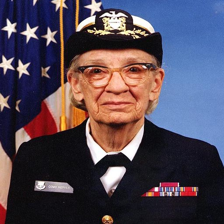

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decode the Prediction

16384/10484 [==============================================] - 0s 0us/step


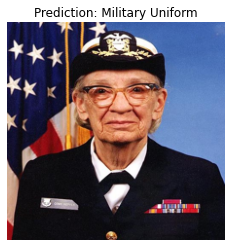

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Use a TensorFlow Hub models for the Cats vs. Dogs dataset
## Dataset

In [11]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

    | 0/1 [03:52<?, ? url/s]
Generating train examples...: 100%|█████████▉| 23170/23262 [00:16<00:00, 1469.78 examples/s]WARNING:absl:1738 images were corrupted and were skipped

                                                                                            
Shuffling cats_vs_dogs-train.tfrecord...:  98%|█████████▊| 22702/23262 [00:01<00:00, 25438.94 examples/s]
Dataset cats_vs_dogs downloaded and prepared to /home/ritesh/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [12]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [13]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Italian greyhound', 'tabby', 'Persian cat', 'Walker hound',
       'golden retriever', 'basset', 'tabby', 'Egyptian cat', 'tabby',
       'Egyptian cat', 'tabby', 'Labrador retriever', 'lion',
       'Siamese cat', 'Siamese cat', 'redbone', 'French bulldog', 'tabby',
       'tabby', 'Eskimo dog', 'Japanese spaniel', 'redbone', 'tabby',
       'tabby', 'papillon', 'Chesapeake Bay retriever', 'tabby',
       'dogsled', 'tabby', 'American Staffordshire terrier',
       'flat-coated retriever', 'Dandie Dinmont'], dtype='<U30')

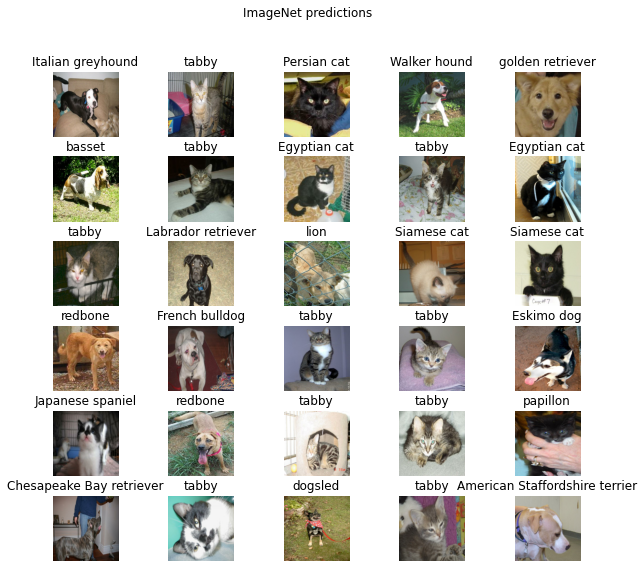

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Do simple transfer learning with TensorFlow Hub

In [16]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [17]:
feature_extractor.trainable = False